In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PriorVAE: comparing training with new data on every epoch (i.e. every training step = new data), vs reusing the same data on each epoch

In [9]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive


In [10]:
path = "./learnt_models/07_args_shorter_training.dill" # 

with open(path, "rb") as f:
    args = dill.load(f)


In [11]:

from reusable.util import decoder_filename, get_savepath
import matplotlib.pyplot as plt
from plotting.plots import plot_training,  plot_draws, plot_draws_hpdi

from reusable.gp import OneDGP
from reusable.vae import vae_sample

from reusable.vae import VAE_Decoder

rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


plot_gp_predictive = Predictive(OneDGP, num_samples=1000)
gp_draws = plot_gp_predictive(rng_key_gp, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

# Comparing training plots

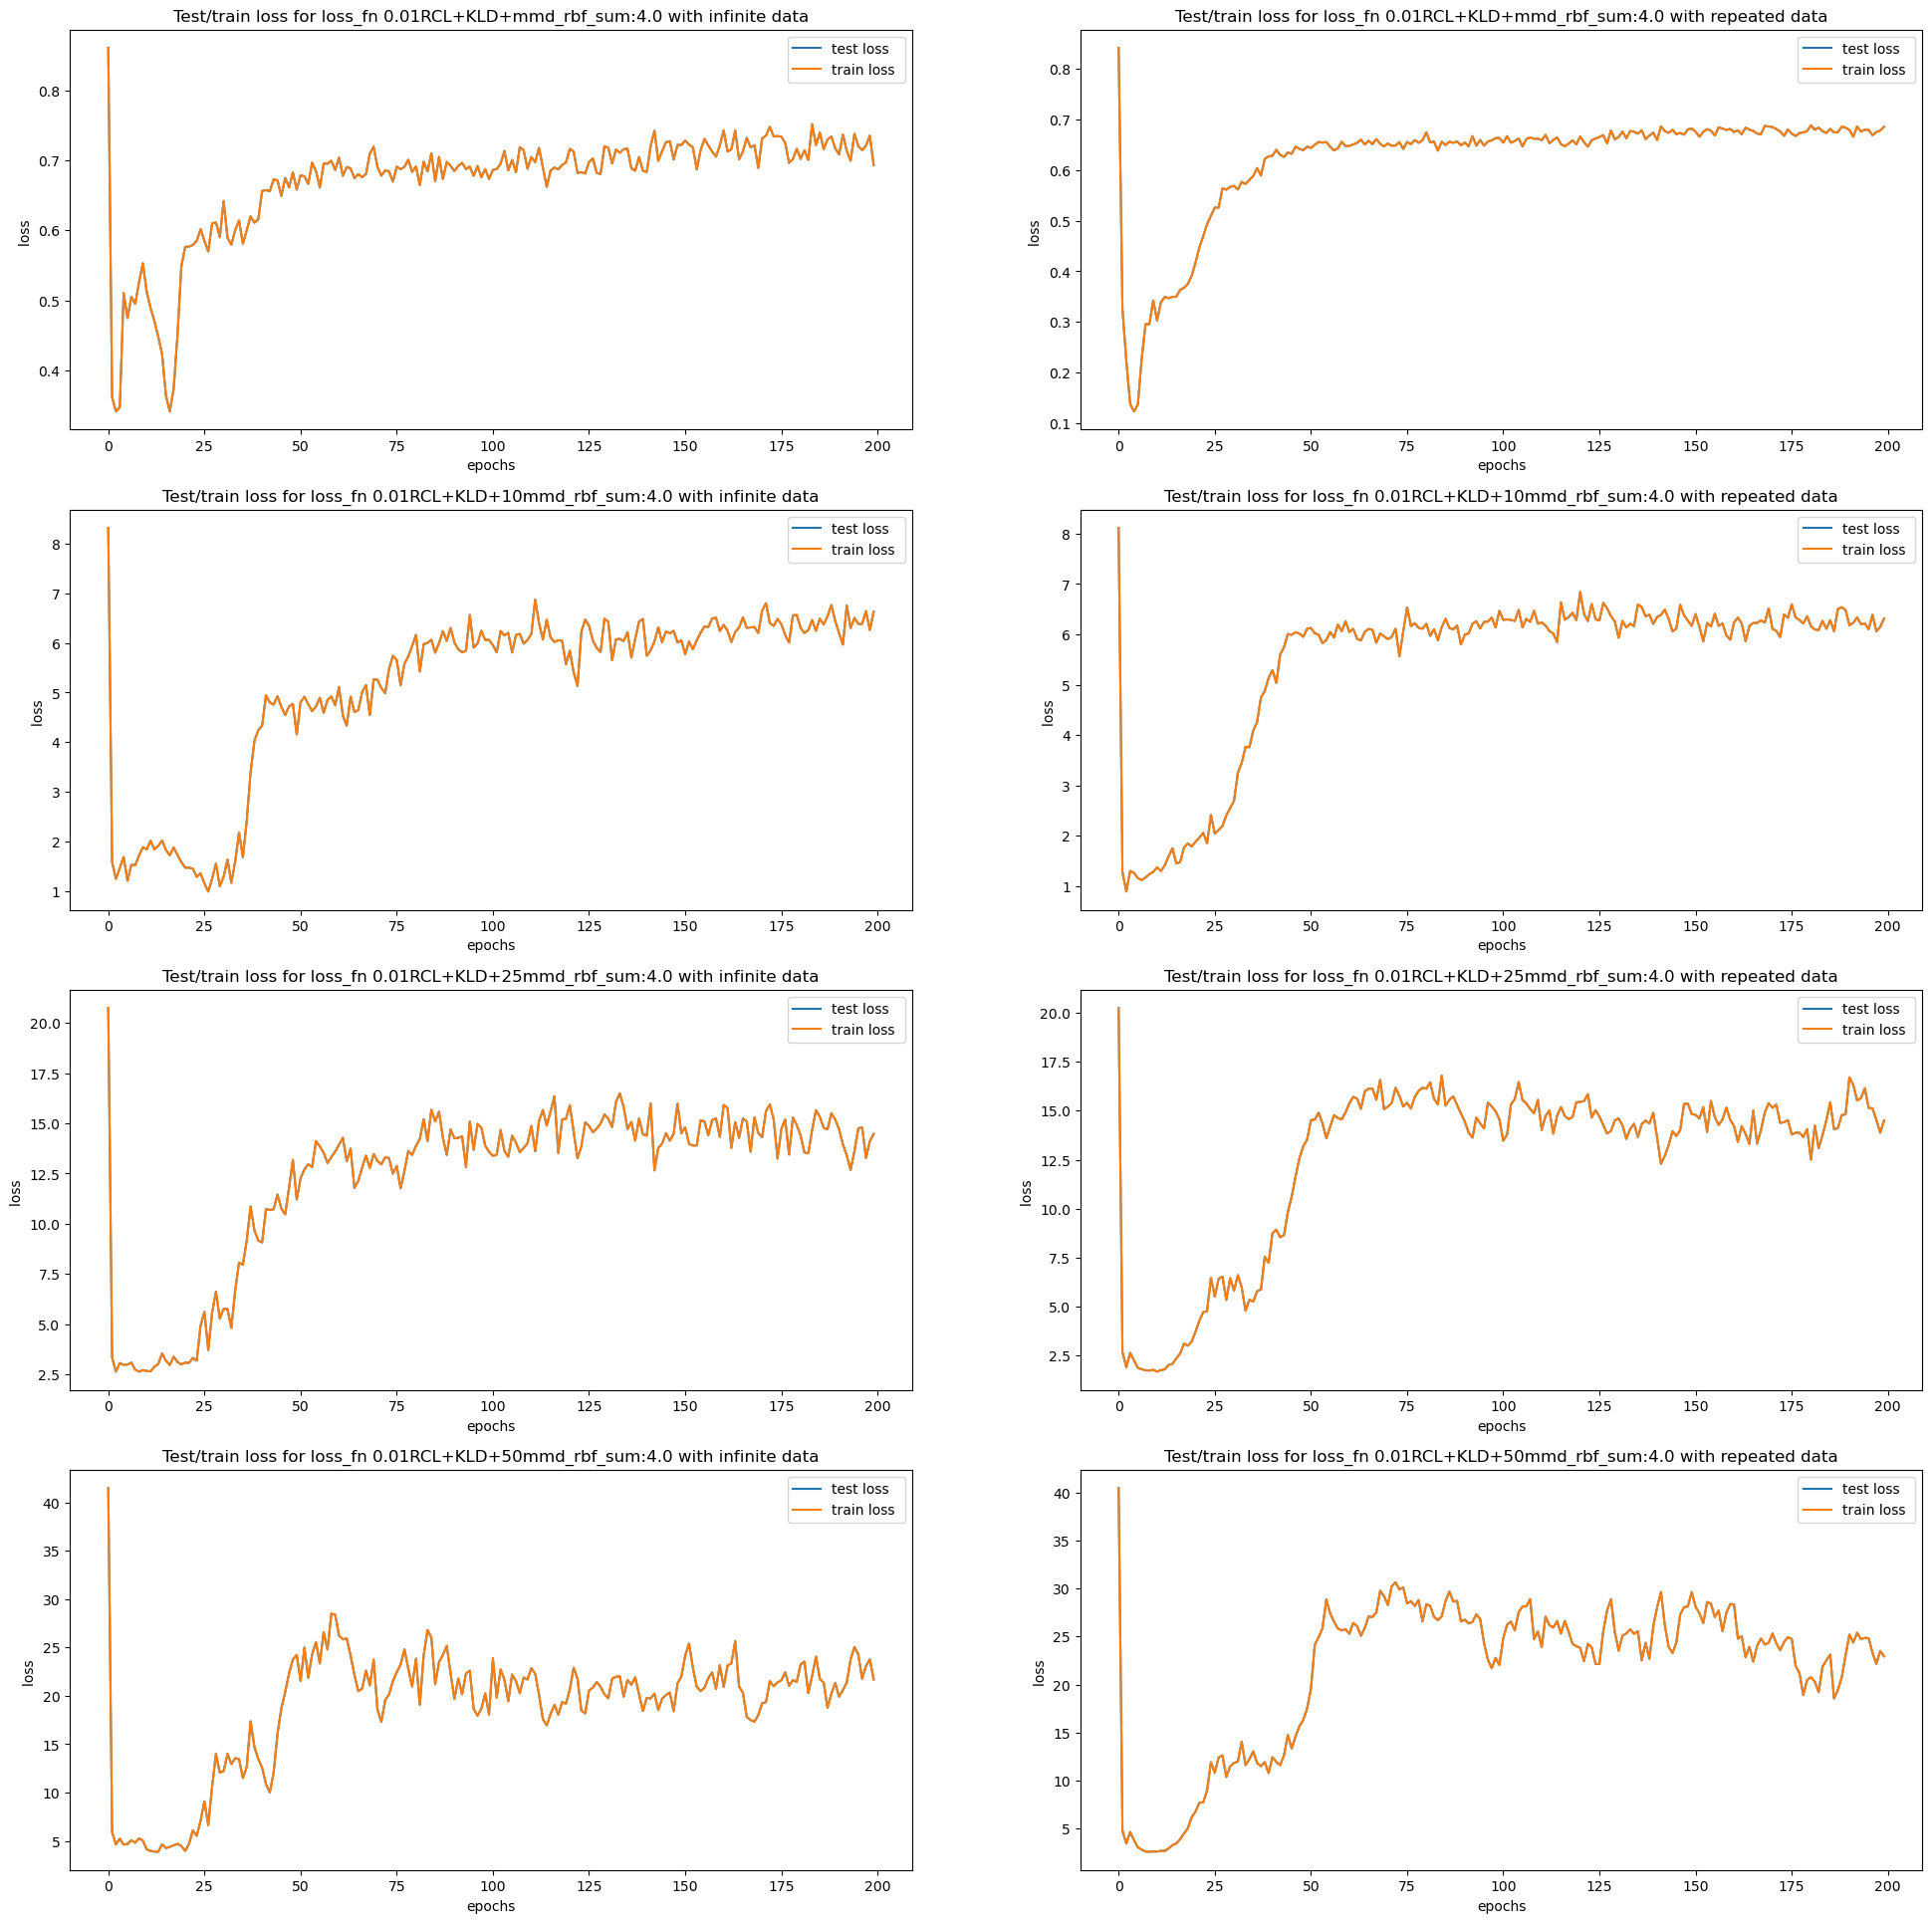

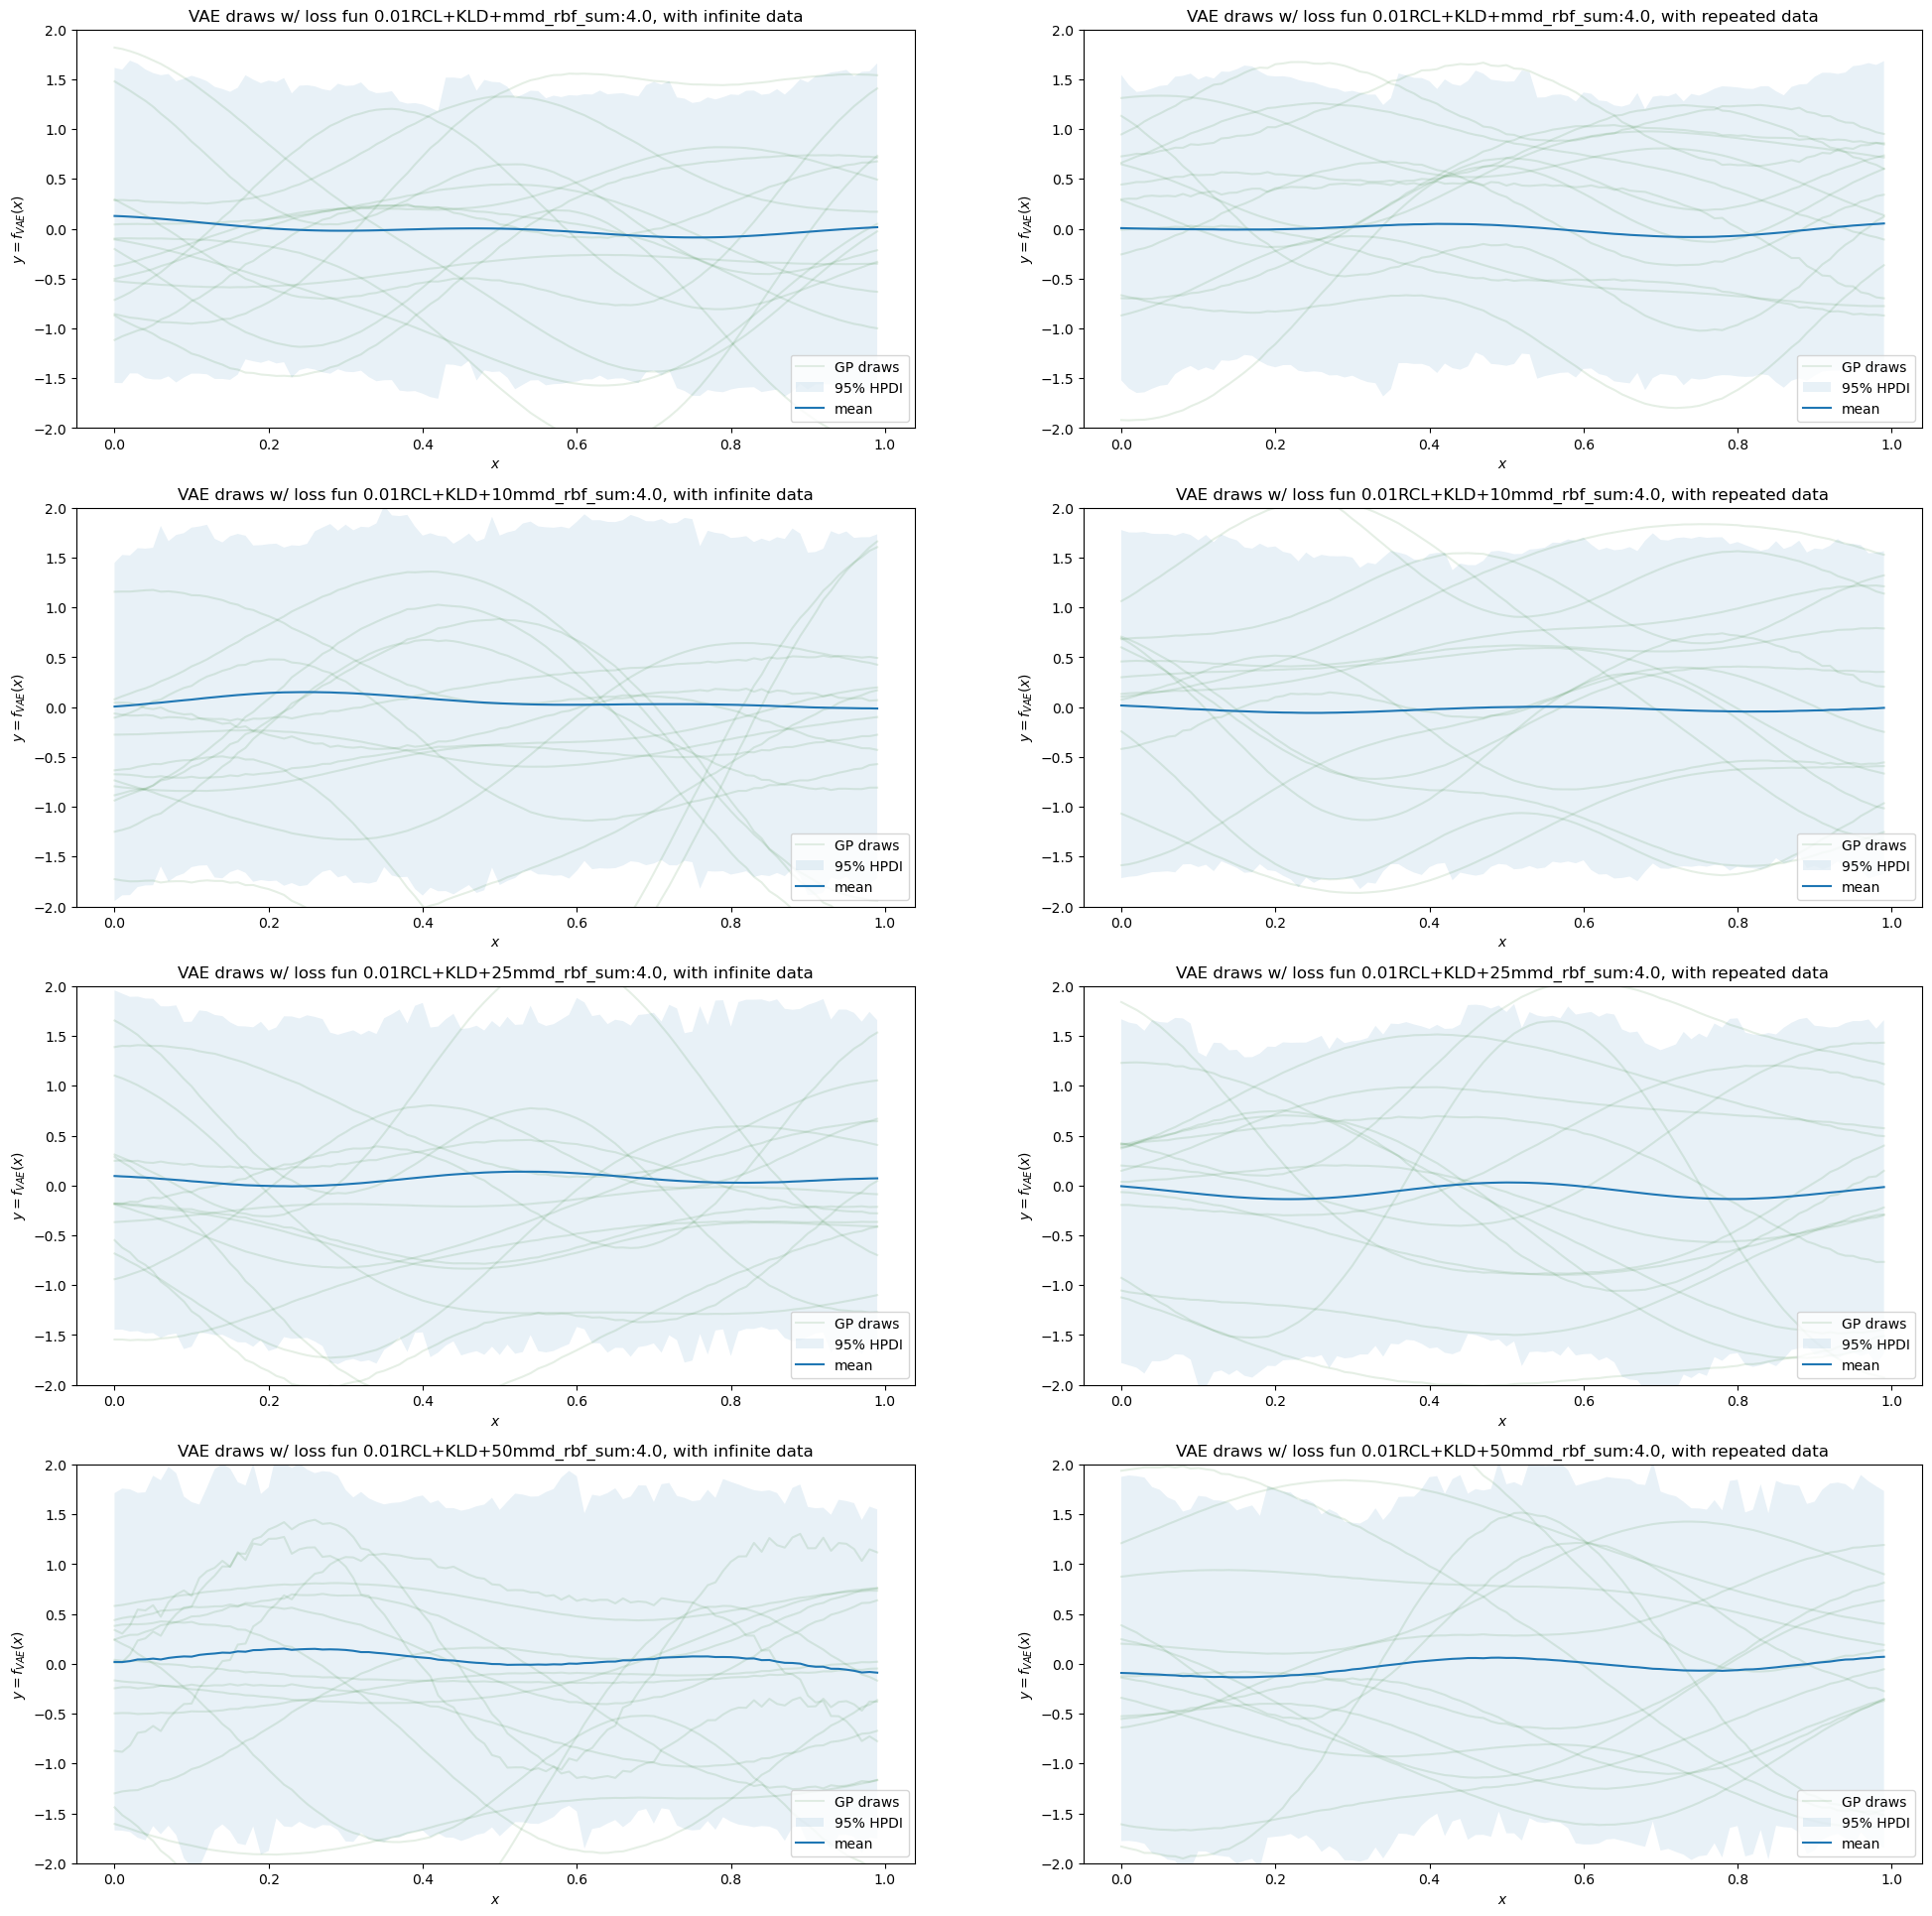

In [13]:
training_fig, training_axs = plt.subplots(nrows=len(args["loss_functions"]), ncols=2, figsize=(24,24))

draws_fig, draws_axs = plt.subplots(nrows=len(args["loss_functions"]), ncols=2, figsize=(24,24))

for i, loss_fn in enumerate(args["loss_functions"]):
    for j in [0,1]:
        infinite = j ==0
        path_inf = "_inf" if infinite else ""
        str_inf = "with infinite data" if infinite else "with repeated data"

        file_path = f'{get_savepath()}/{decoder_filename("07", args, suffix=loss_fn+"_metrics_hist"+path_inf)}'

        try: 
            with open(file_path, 'rb') as file:
                metrics_history = dill.load(file)
            plot_training(
                metrics_history["test_loss"], 
                metrics_history["train_loss"], 
                f"Test/train loss for loss_fn {loss_fn} " + str_inf,
                "loss ",
                training_axs[i,j]
            )

        except FileNotFoundError:
            print(f"Failed to load metrics history for loss_fn={loss_fn}, j={j}")

        file_path = f'{get_savepath()}/{decoder_filename("07", args, suffix=loss_fn+path_inf)}'

        try:
            dummy_decoder = VAE_Decoder(
                hidden_dim1=args["hidden_dim1"], hidden_dim2=args["hidden_dim2"], out_dim=args["n"]
            )
            dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))

            with open(file_path, "rb") as file:
                bytes = file.read()

                args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

            plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
            vae_draws = plot_vae_predictive(
                rng_key_predict,
                hidden_dim1=args["hidden_dim1"],
                hidden_dim2=args["hidden_dim2"],
                latent_dim=args["latent_dim"],
                out_dim=args["n"],
                decoder_params=args["decoder_params"],
            )["f"]

            plot_draws_hpdi(vae_draws, args["x"], f"VAE draws w/ loss fun {loss_fn}, {str_inf}", "$y=f_{VAE}(x)$", ax=draws_axs[i, j])
        except FileNotFoundError:
            print(f"Failed to load decoder params for loss_fn={loss_fn}, j={j}")